In [13]:
import gym
import time
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

plt.style.use('ggplot')

torch.manual_seed(42)
random.seed(42)

# set the GPU
device = torch.device("cuda:0")

## Deep Q-Learning (DQN)

epoch:   0 	 epsilon: 0.808, total frames: 10, mean return last 100 episodes: 10.00
Elapsed time:  00:00:00
epoch: 100 	 epsilon: 0.020, total frames: 5124, mean return last 100 episodes: 51.14
Elapsed time:  00:00:07
epoch: 200 	 epsilon: 0.020, total frames: 30986, mean return last 100 episodes: 258.62
Elapsed time:  00:00:47
epoch: 300 	 epsilon: 0.020, total frames: 61872, mean return last 100 episodes: 308.86
Elapsed time:  00:01:35
epoch: 400 	 epsilon: 0.020, total frames: 102438, mean return last 100 episodes: 405.66
Elapsed time:  00:02:40




Average reward: 278.21
Average reward (last 100 episodes): 366.77


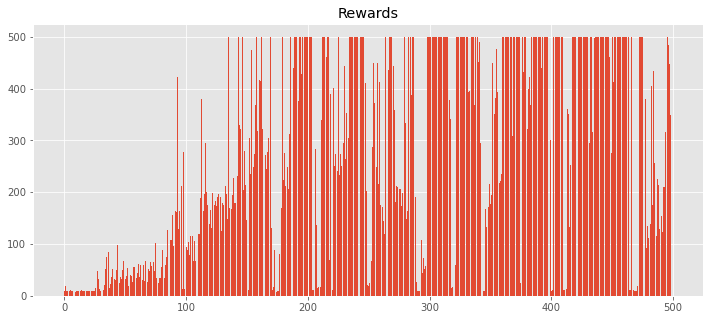

In [18]:
env = gym.make('CartPole-v1')
env.seed(42)

class NeuralNetwork(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_size=64):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(obs_dim, hidden_size)
        self.linear2 = nn.Linear(hidden_size, act_dim)
        self.activation = nn.Tanh()
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x
    
class DQN(object):
    def __init__(self, env, lr=0.01, gamma=0.99, hidden_size=64):
        self.env = env
        obs_dim = env.observation_space.shape[0]
        act_dim = env.action_space.n
        
        self.gamma = gamma
        self.nn = NeuralNetwork(obs_dim, act_dim, hidden_size).to(device)
        self.loss_func = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=lr)
        
        # Decaying eps-greedy
        self.epsilon = 0.9
        self.epsilon_target = 0.02
        self.epsilon_decay = 500
        
    def select_action(self, obs):
        """Selects action from the learned Q-function
        """
        if torch.rand(1)[0] > self.epsilon:      
            with torch.no_grad():
                obs = torch.Tensor(obs).to(device)
                act = self.nn(obs)
                act = torch.max(act, 0)[1]
                act = act.item()        
        else:
            act = env.action_space.sample()
        return act
    
    def update(self, obs, action, new_obs, reward, done):
        """Perform the update rule on the function approximator,
           the Neural Network
        """
        # Push tensors to device
        obs = torch.Tensor(obs).to(device)
        new_obs = torch.Tensor(new_obs).to(device)
        reward = torch.Tensor([reward]).to(device)
        
        if done:
            target_value = reward
        else:
            n_obs_values = self.nn(new_obs).detach()
            max_values = torch.max(n_obs_values)
            target_value = reward + self.gamma * max_values
        
        predicted_value = self.nn(obs)[action]
        
        loss = self.loss_func(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def _calculate_epsilon(self, frames):
        self.epsilon = self.epsilon_target + (self.epsilon - self.epsilon_target) * \
                  np.exp(-1. * frames / self.epsilon_decay)
    
    def plot(self, steps_total, num_episodes):
        print("\n\n\n\nAverage reward: %.2f" % (sum(steps_total)/num_episodes))
        print("Average reward (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))
        
        plt.figure(figsize=(12,5))
        plt.title("Rewards")
        plt.ylabel("Episode length")
        plt.xlabel("Episode")
        plt.bar(torch.arange(len(steps_total)), steps_total)
        plt.show()
        
    def learn(self, num_episodes=500, report_interval=100):
        steps_total = []
        total_frames = 0 
        start_time = time.time()
        
        for i_episode in range(num_episodes):
            obs = self.env.reset()
            step = 0
            while True:
                # Increment counters
                step += 1
                total_frames += 1
                
                self._calculate_epsilon(total_frames)

                action = self.select_action(obs)
                new_obs, reward, done, _ = self.env.step(action)
                
                # Perform the update rule
                self.update(obs, action, new_obs, reward, done)
                obs = new_obs
                
                if done:
                    steps_total.append(step)

                    mean_reward_100 = sum(steps_total[-100:])/100
            
                    if (i_episode % report_interval == 0):
                    
                        print('epoch: %3d \t epsilon: %.3f, total frames: %i, mean return last 100 episodes: %.2f' %
                          (i_episode, self.epsilon, total_frames, np.mean(steps_total[-100:])))

                        elapsed_time = time.time() - start_time
                        print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
                    break
            
        self.plot(steps_total, num_episodes)

agent = DQN(env)
agent.learn()